In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (concatenate, Input, Reshape, Dense, Flatten,
                                     Dropout, BatchNormalization, Lambda, LeakyReLU, 
                                     Conv2D, Conv2DTranspose, MaxPooling2D)
from tensorflow.keras.utils import plot_model
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import StandardScaler
from sklearn import manifold
from sklearn.manifold import TSNE 
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering

from scipy import ndimage

%matplotlib inline

In [ ]:
(X_train, X_test), (y_train, y_test) = mnist.load_data()

X_train = X_train.reshape(len(X_train), 28, 28, 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (60000,), (10000, 28, 28), (10000,))

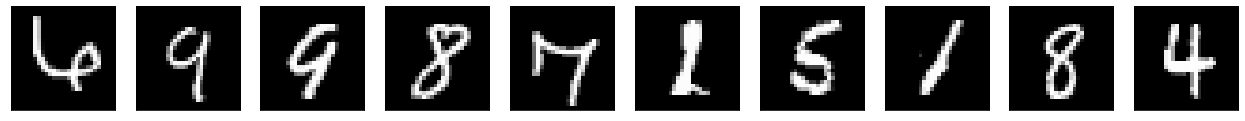

In [ ]:
# Функция вывода оригинальных изображений
n = 10
plt.figure(figsize=(22,6))
for i in range(n):
    index = np.random.randint(0, X_train.shape[0])
    ax=plt.subplot(1, n, i + 1)
    plt.imshow(X_train[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
X = np.reshape(X_train, (len(X_train), -1))

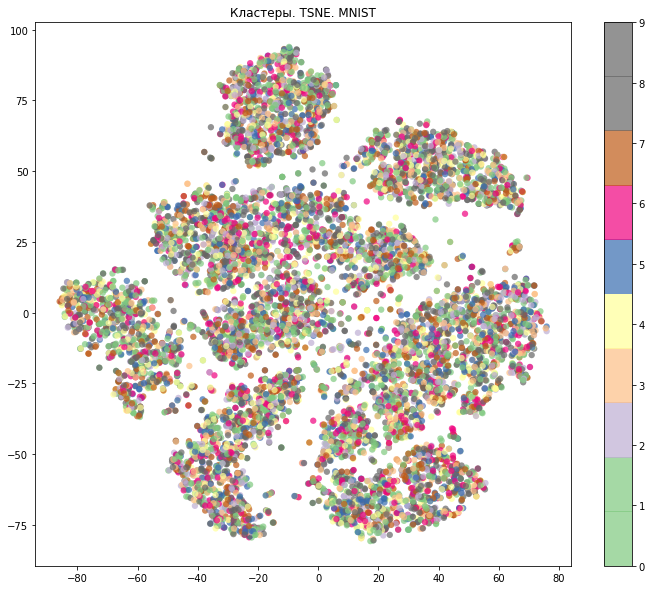

In [ ]:
# Вывод кластеров набора mnist
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X[:10000])

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('Accent', 10))
plt.colorbar()
plt.title('Кластеры. TSNE. MNIST')
plt.show()

In [ ]:
input_img = Input(shape=(28, 28, 1))

ent = Flatten()(input_img)
ent = Dense(128, activation='relu')(ent)
ent = Dropout(0.3)(ent)
ent = BatchNormalization()(ent)
ent = Dense(64, activation='relu')(ent)
ent = Dropout(0.2)(ent)
ent = BatchNormalization()(ent)
encoded = Dense(10, activation='sigmoid')(ent)

input_enc = Input(shape=(10,))
d = Dense(64, activation='relu')(input_enc)
d = Dropout(0.2)(d)
d = BatchNormalization()(d)
d = Dense(128, activation='relu')(d)
d = Dropout(0.3)(d)
d = BatchNormalization()(d)
d = Dense(28*28, activation='relu')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_enc, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

autoencoder.fit(X_train, X_train, epochs=100, batch_size=100)

Epoch 1/100
600/600 [==============================] - 7s 9ms/step - loss: 7210.1440
Epoch 2/100
600/600 [==============================] - 6s 9ms/step - loss: 6923.3335
Epoch 3/100
600/600 [==============================] - 5s 9ms/step - loss: 6631.8042
Epoch 4/100
600/600 [==============================] - 5s 9ms/step - loss: 6371.0884
Epoch 5/100
600/600 [==============================] - 5s 9ms/step - loss: 6133.6045
Epoch 6/100
600/600 [==============================] - 5s 9ms/step - loss: 5917.5874
Epoch 7/100
600/600 [==============================] - 5s 9ms/step - loss: 5726.7183
Epoch 8/100
600/600 [==============================] - 5s 9ms/step - loss: 5564.3120
Epoch 9/100
600/600 [==============================] - 5s 9ms/step - loss: 5434.8613
Epoch 10/100
600/600 [==============================] - 5s 9ms/step - loss: 5335.9780
Epoch 11/100
600/600 [==============================] - 5s 9ms/step - loss: 5261.6885
Epoch 12/100
600/600 [==============================] - 5s 9ms/

In [ ]:
# Решейп encoder для кластеризации
X_en = encoder.predict(X[:10000].reshape((10000, 28, 28, 1)), batch_size=100)

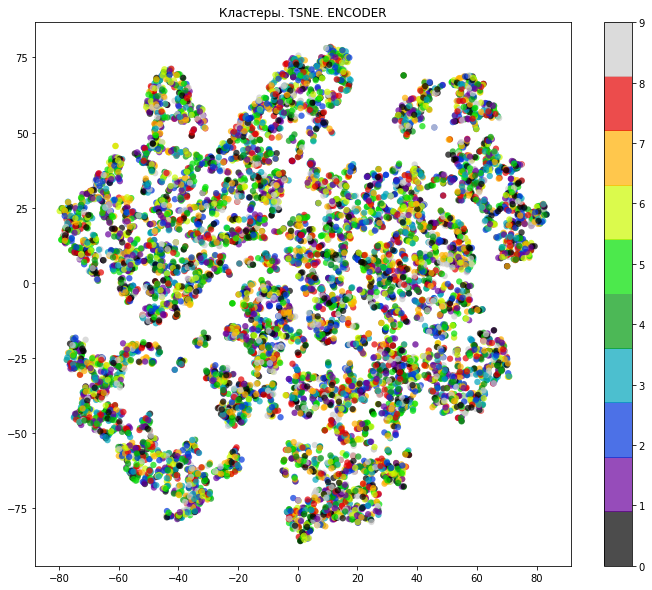

In [ ]:
# Вывод кластеров набора mnist
tsne = TSNE(n_components=2, random_state=17)
X_tsne = tsne.fit_transform(X_en)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))   #Accent
plt.colorbar()
plt.title('Кластеры. TSNE. ENCODER')
plt.show()

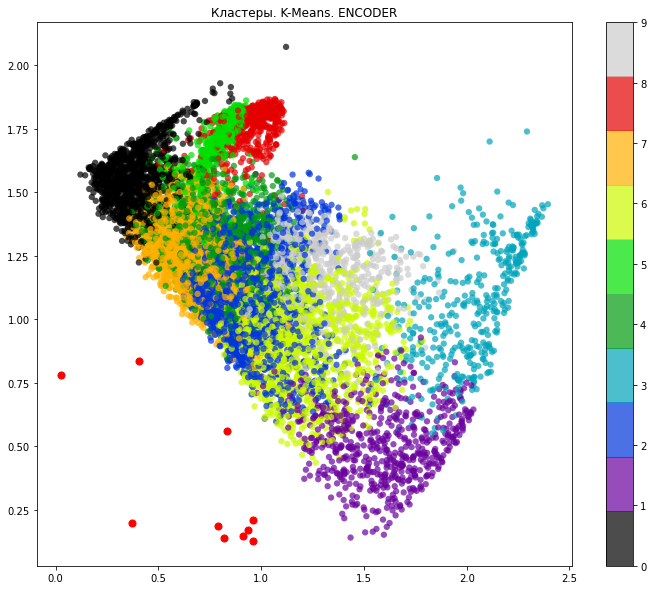

In [ ]:
n_clusters = 10
kmeans = KMeans(n_clusters, n_init=500, random_state=17)
e_kmeans = kmeans.fit_transform(X_en)
labels = kmeans.labels_
 

plt.figure(figsize=(12, 10))
plt.scatter(e_kmeans[:, 0], e_kmeans[:, 1], c=labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))   #Accent
plt.colorbar()
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 50, alpha = 1)
plt.title('Кластеры. K-Means. ENCODER')
plt.show()

[(2, 0.5415343862857644), (3, 0.713025804407085), (4, 0.6972976453786004), (5, 0.9307949092664034), (6, 0.5607123717193617), (7, 1.003818937085628), (8, 0.8813747801400434), (9, 0.93697580056469), (10, 0.6658944579581043)]


Text(0, 0.5, '')

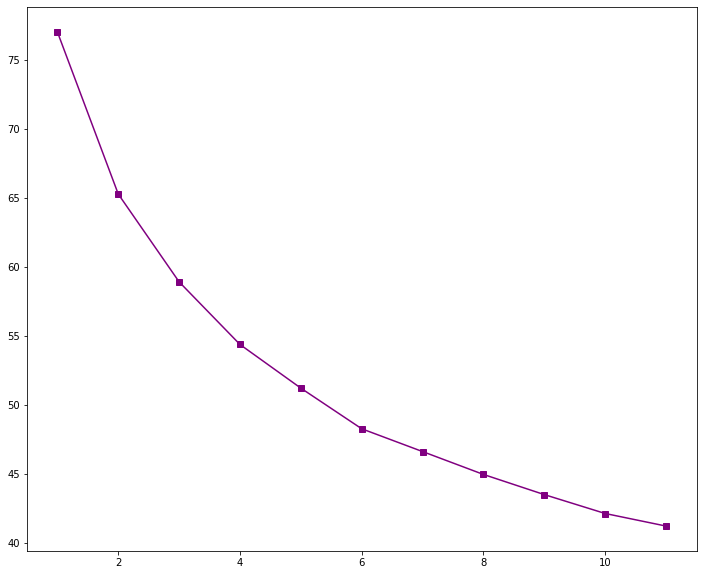

In [ ]:
# График колен
N = [i + 1 for i in range(11)]
inertia = []
for k in N:
    kmeans = KMeans(n_clusters=k, random_state=1, n_jobs=4).fit(X_en)
    inertia.append(np.sqrt(kmeans.inertia_))

d_list = [(i + 1, abs((inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])))  for i in range(1, len(inertia) - 1)]
print(d_list)

plt.figure(figsize=(12,10))
plt.plot(N, inertia, marker='s', color='purple')
plt.xlabel('')
plt.ylabel('')

In [ ]:
print(labels[:50])

[7 1 9 8 4 2 5 6 5 0 7 8 6 2 5 0 2 7 2 0 9 1 0 8 2 6 4 6 6 0 2 7 2 0 6 7 2
 6 4 2 5 7 0 0 4 0 7 7 4 6]


In [ ]:
# Размер каждого кластера
cluster_size = [sum(labels == i) for i in range(0, n_clusters)]
for i, s in enumerate(cluster_size):
    print(f'Кластер: {i} Размер= {s}')

Кластер: 0 Размер= 1118
Кластер: 1 Размер= 618
Кластер: 2 Размер= 1961
Кластер: 3 Размер= 390
Кластер: 4 Размер= 1189
Кластер: 5 Размер= 619
Кластер: 6 Размер= 1289
Кластер: 7 Размер= 1628
Кластер: 8 Размер= 578
Кластер: 9 Размер= 610


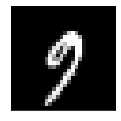

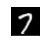

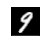

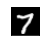

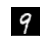

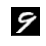

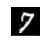

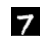

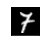

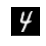

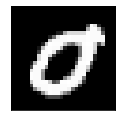

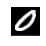

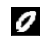

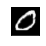

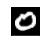

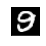

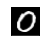

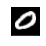

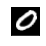

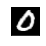

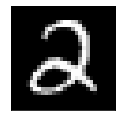

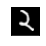

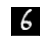

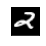

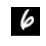

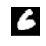

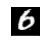

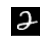

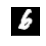

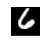

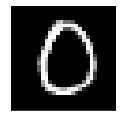

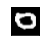

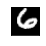

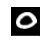

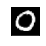

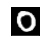

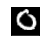

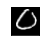

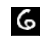

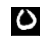

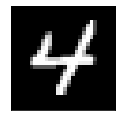

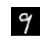

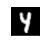

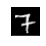

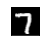

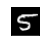

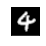

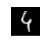

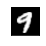

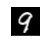

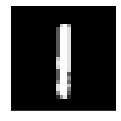

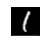

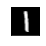

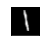

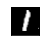

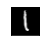

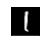

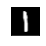

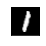

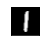

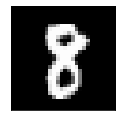

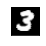

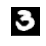

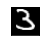

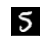

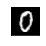

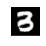

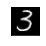

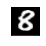

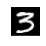

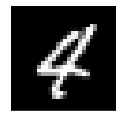

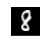

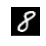

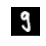

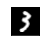

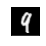

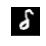

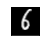

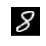

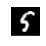

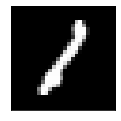

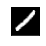

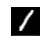

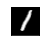

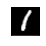

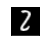

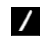

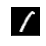

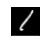

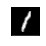

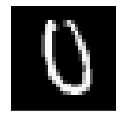

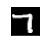

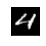

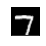

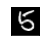

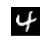

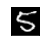

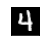

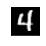

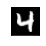

In [ ]:
def view_cluster(c, shape=(28, 28)):
    n = 10
    indexes = labels == c
    claster_items = X_train[:10000][indexes]
    plt.figure(figsize=(22, 6))
    for i in range(n):
        index = np.random.randint(0, claster_items.shape[0])
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(claster_items[index].reshape(shape))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()

view_cluster(0)
view_cluster(1)
view_cluster(2)
view_cluster(3)
view_cluster(4)
view_cluster(5)
view_cluster(6)
view_cluster(7)
view_cluster(8)
view_cluster(9)


Иерархическая кластеризация

In [ ]:
cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  # Создаем объект AgglomerativeClustering
agglomerative = cluster.fit_predict(X_en)
agglomerative.shape

(10000,)

In [ ]:
labels = cluster.labels_ # Получаем список меток
print(labels[:10])

[0 4 6 7 1 0 5 0 5 2]


In [ ]:
n_cluster = 5                             # Указываем номер кластера
print(X_en[labels == n_cluster,:])        # Кластер
print(len(X_en[labels == n_cluster,:]))   # Размер кластера

[[0.9485053  0.20270225 0.80738103 ... 0.42620558 0.660472   0.82165825]
 [0.90333855 0.32105905 0.7755188  ... 0.55670094 0.7131521  0.914171  ]
 [0.91888547 0.24123445 0.7945428  ... 0.66825724 0.71474206 0.9194174 ]
 ...
 [0.95913064 0.13818222 0.83975124 ... 0.67065036 0.6703402  0.91407716]
 [0.9028746  0.19546318 0.8092129  ... 0.8928079  0.7935225  0.8728252 ]
 [0.9870147  0.05571747 0.85990846 ... 0.93787014 0.7081193  0.57537395]]
712


In [ ]:
n_samples, n_features = X.shape
np.random.seed(0)

In [ ]:
def nudge_images(X, y_test):

    shift = lambda x: ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X_en, np.apply_along_axis(shift, 1, X_en)])
    Y = np.concatenate([labels, labels], axis=0)
    return X, Y


X, Y = nudge_images(X_en, y_test)

ValueError: ignored

In [ ]:
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(12, 10))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(labels[i]), 
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Computing embedding
Done.


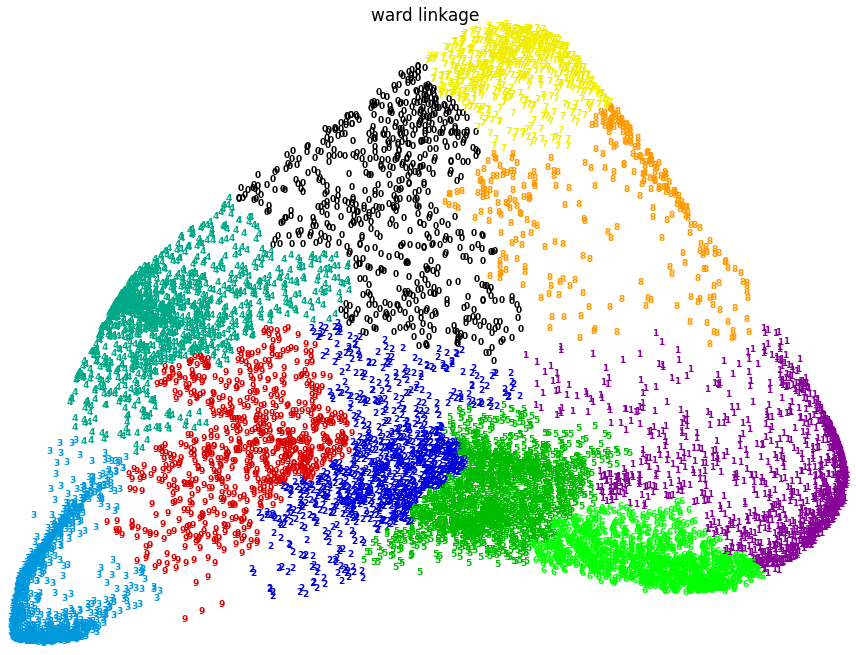

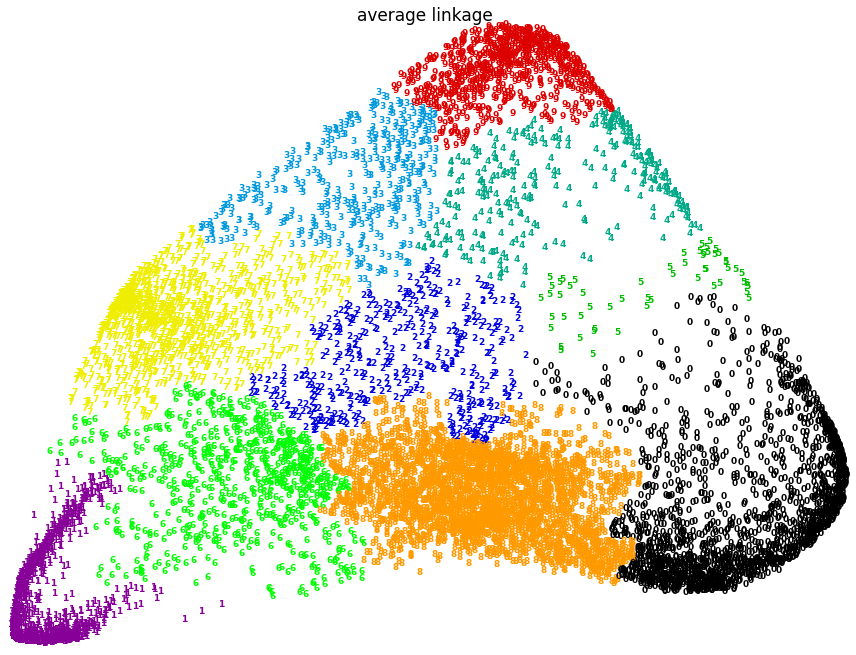

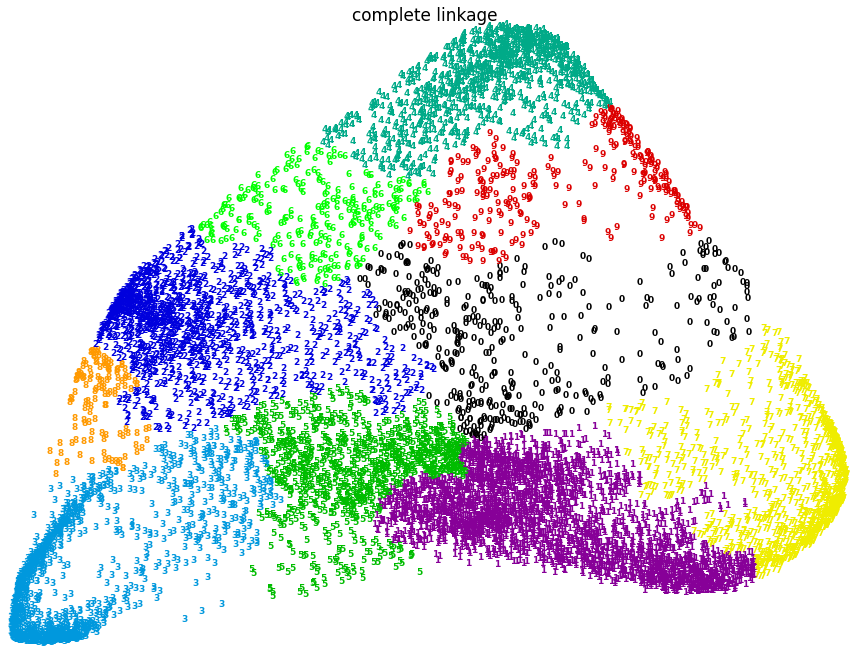

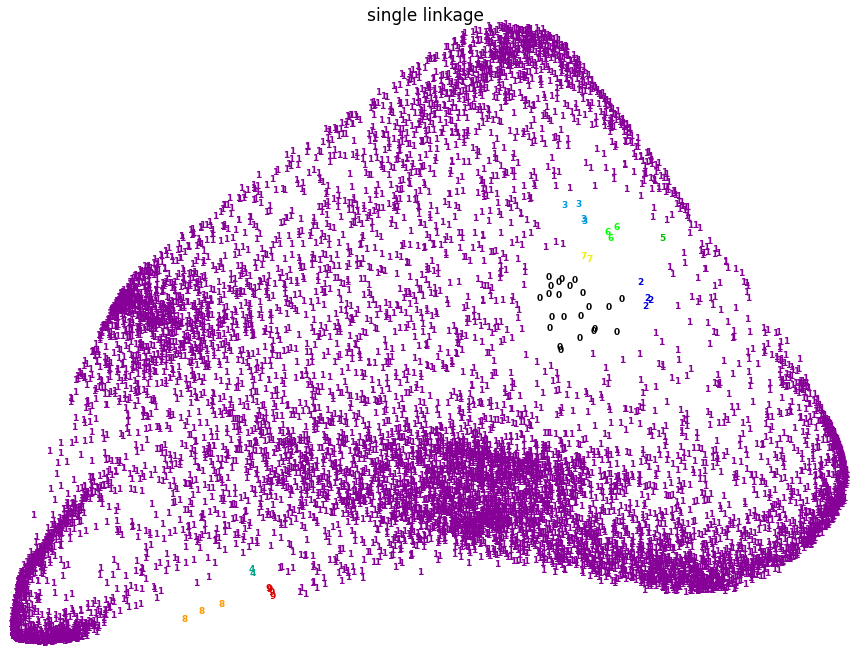

In [ ]:
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X_en)
print("Done.")

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    clustering.fit(X_red)
    
    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()